In [1]:
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.spatial.distance import cdist 
from scipy.special import kv, gamma

from sklearn.metrics import root_mean_squared_error
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings('ignore')

Funciones

In [2]:
matern_model = lambda t, nu: np.vectorize(lambda x: 2**(1-nu) / gamma(nu) * (t*x)**nu * kv(nu, t*x))

def cov_matrix(cov_model, X_1, X_2):
    return np.nan_to_num(cov_model(cdist(X_1,X_2)), nan=1)

In [3]:
def gen_A(X, n_clusters):
    KM = KMeans(n_clusters=n_clusters).fit(X)
    A = [[] for _ in range(n_clusters)]
    for i, label in enumerate(KM.labels_):
        A[label].append(i)
    return A

Kriging simple

In [4]:
def kriging(x, X, Y, sigma, cov):
    '''
    x : prediction point
    X : the vector of observation points
    Y : observations
    sigma : covariance matrix of observations
    cov : covariance function cov(h) 
    '''
    return cov_matrix(cov, x, X) @ np.linalg.solve(sigma, Y)

NestedKriging

In [5]:
class NestedKriging:
    '''
    Implements Nested Kriging for predicting outputs based on observations.

    This class provides functionality for predicting outputs using Nested Kriging,
    a method described in the paper "Nested Kriging predictions for datasets with a 
    large number of observations" by Rullière et al. (2018).

    Parameters
    ----------
    X : array-like
        Vector of all observation points.
    Y : array-like
        All observations.
    cov : function
        Isotropic covariance function. C: h -> C(h) 
    theta : float
        Scale parameter for the Matérn covariance model.
    nu : float
        Smoothness parameter for the Matérn covariance model.

    Attributes
    ----------
    X : array-like
        Vector of all observation points.
    Y : array-like
        All observations.
    theta : float or None
        Scale parameter for the Matérn covariance model.
    nu : float or None
        Smoothness parameter for the Matérn covariance model.
    cov : function or None
        Isotropic covariance function. C: h -> C(h) 
    sigma : array-like or None
        Covariance matrix of the observation points.
    ZZZ : array-like or None
        Large matrix used in nested kriging predictions.

    Methods
    -------
    nk(x, A)
        Predicts the output at a given prediction point using nested kriging.
    predict(X_test, A)
        Predicts the output for the given prediction points using nested kriging.
    gen_big_matrix(A, lens_A, cumsum_lens_A)
        Generates a large matrix for nested kriging predictions.
    '''
    def __init__(self, X, Y, cov=None, theta=None, nu=None):
        if len(X) != len(Y):
            raise ValueError(
            "Found input variables with inconsistent numbers of dimensions: %r"
            % [len(X), len(Y)]
            )        
        if theta is not None and nu is not None:
            if theta <= 0 or nu <= 0:
                raise ValueError("Found a non-positive parameter.")
        self.X = X
        self.Y = Y
        self.theta = theta
        self.nu = nu
        
        self.cov = matern_model(self.theta, self.nu) if cov is None else cov 
        
        self.sigma = None
        self.ZZZ = None
            
    def nk(self, x, A):
        '''
        Predicts the output at a given prediction point using nested kriging.

        This method implements nested kriging as described in the paper:
        "Nested Kriging predictions for datasets with a large number of observations"
        by Rullière et al. (2018).

        Parameters
        ----------
        x : array-like
            Prediction point.
        A : list of lists
            List of lists containing submodel indexes.

        Returns
        -------
        array
            Predicted output at the given prediction point using nested kriging.
        '''
        
        if self.sigma is None:
            self.sigma = cov_matrix(self.cov, self.X, self.X)
        
        k_x_X = cov_matrix(self.cov, self.X, x)    
        lens_A = [len(sublist) for sublist in A]
        cumsum_lens_A = np.cumsum(lens_A)
        
        if self.ZZZ is None:
            self.gen_big_matrix(A, lens_A, cumsum_lens_A)
        
        pivot, C = 0, np.zeros((sum(lens_A), len(A)))
        M = np.zeros((len(A), 1))
        
        for i in range(len(A)):
            C[pivot:(pivot+lens_A[i]), [i]] = np.linalg.solve(self.sigma[A[i], :][:, A[i]], k_x_X[A[i], :])
            M[i] = C[pivot:(pivot+lens_A[i]), [i]].T @ self.Y[A[i]]
            pivot+=lens_A[i]
            
        # cov(M, M) = C.T @ ZZZ @ C
        # cov(M, Y) = diag(C.T @ ZZZ @ C)
        
        K_M = C.T @ self.ZZZ @ C
        return np.diag(K_M) @ np.linalg.solve(K_M, M)
    
    def predict(self, X_test, A):
        '''
        Predicts the output for the given prediction points.

        Parameters
        ----------
        X_test : array-like
            Array containing prediction points.
        A : list of list
            List of lists containing submodel indexes.

        Returns
        -------
        array
            Array containing the predicted outputs for the given prediction points.
        '''
        return np.array([self.nk(X_test[[i]], A) for i in range(len(X_test))])
    
    def gen_big_matrix(self, A, lens_A, cumsum_lens_A):
        '''
        Generates a large matrix for nested kriging predictions.

        This method constructs a large matrix used in nested kriging predictions, 
        composed of blocks of the form cov(X_i, X_j), where X_i represents the points 
        considered in submodel i.

        Parameters
        ----------
        A : list of lists
            List of lists containing submodel indexes.
        lens_A : list
            List containing the lengths of submodel indexes.
        cumsum_lens_A : array-like
            Cumulative sum of lengths of submodel indexes.

        Returns
        -------
        None
        '''
        row, self.ZZZ = 0, np.zeros((sum(lens_A), sum(lens_A)))
        for i in range(len(A)):
            column=cumsum_lens_A[i]
            for j in range(i+1, len(A)):
                self.ZZZ[row:(row+lens_A[i]), column:(column+lens_A[j])] = self.sigma[A[i], :][:, A[j]]
                column+=lens_A[j]
            row+=lens_A[i]
        self.ZZZ += self.ZZZ.T
        pivot = 0
        for i in range(len(A)):
            self.ZZZ[pivot:(pivot+lens_A[i]), pivot:(pivot+lens_A[i])] = self.sigma[A[i], :][:, A[i]]
            pivot+=lens_A[i]
    

In [6]:
def scatterplot(X,Y,title='',xlabel='',ylabel=''):
    plt.scatter(X,Y)
    plt.plot([min(min(X), min(Y)), max(max(X), max(Y))], [min(min(X), min(Y)), max(max(X), max(Y))], ls = '--', lw = 2, c = 'r')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

Observation points

In [7]:
d = 2
n = 1_000
sup = 20
X = np.random.uniform(0, sup, (n,d))

Parameters

In [8]:
nu = 3/2
theta = 1

Covariance matrix

In [9]:
sigma = cov_matrix(matern_model(theta, nu), X, X)

In [10]:
Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, n)

## 2D

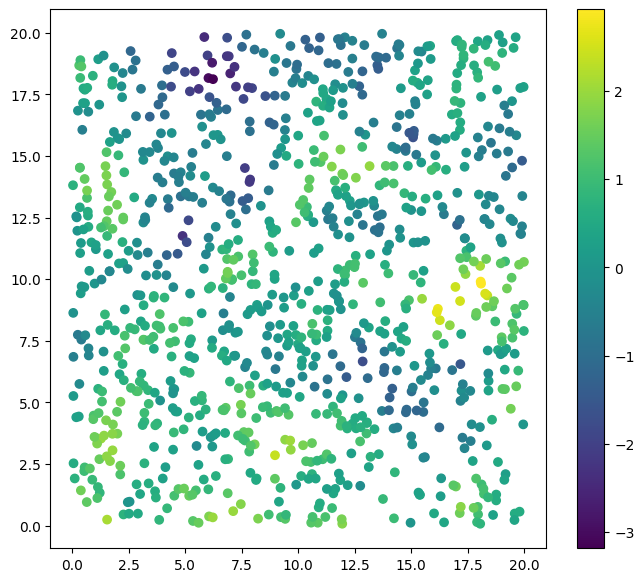

In [11]:
plt.figure(figsize=(8,7))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.colorbar();

Test

In [12]:
n_test = 1_000
X_test = np.random.uniform(0, sup, (n_test, d))

Y_test = np.linalg.cholesky(cov_matrix(matern_model(theta, nu), X_test, X_test)) @ np.random.normal(0, 1, n_test)

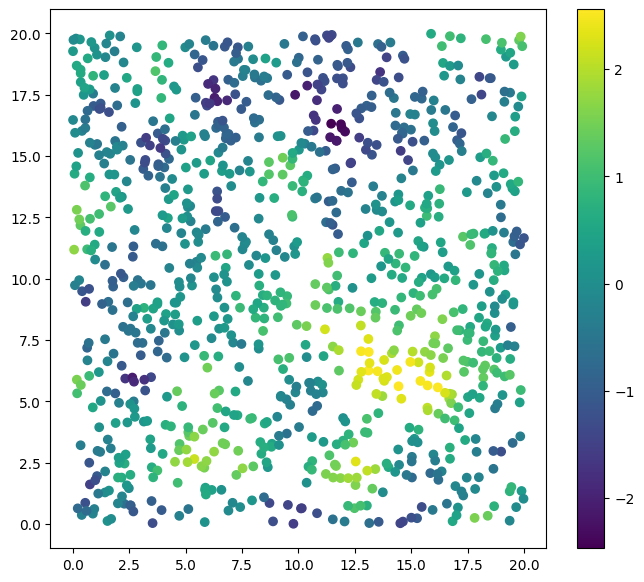

In [13]:
plt.figure(figsize=(8,7))
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)
plt.colorbar();

RMSE = 1.2683702539092323


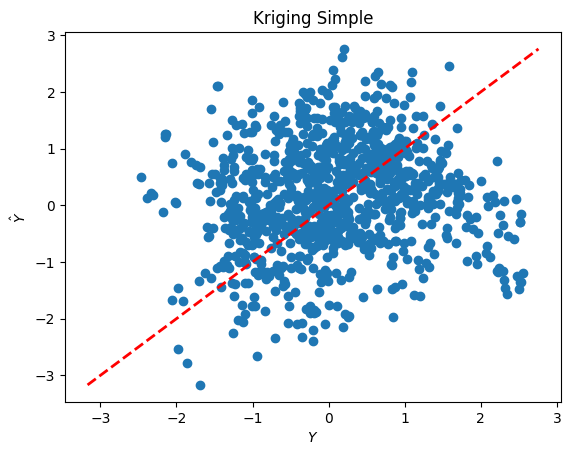

In [14]:
Y_pred_K = kriging(X_test, X, Y, sigma, matern_model(theta, nu))

RMSE = root_mean_squared_error(Y_test, Y_pred_K)
print(f'{RMSE = }')

scatterplot(Y_test, Y_pred_K, title=r'Kriging Simple', xlabel=r'$Y$', ylabel=r'$\hat{Y}$')

In [15]:
A = gen_A(X, 100)

In [17]:
NK = NestedKriging(X, Y, theta=theta, nu=nu)

RMSE = 1.2715855857644798


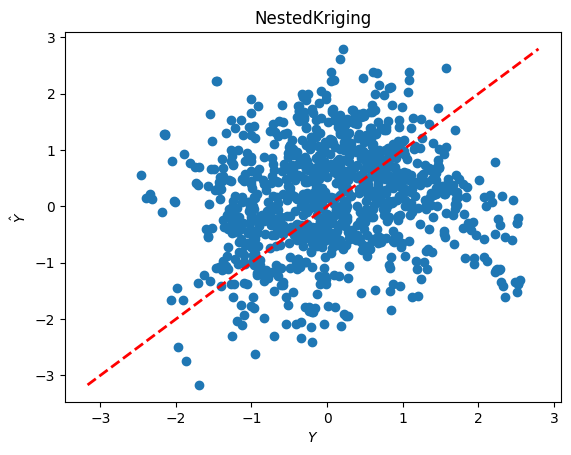

In [21]:
Y_pred_NK = NK.predict(X_test, A)

RMSE = root_mean_squared_error(Y_test, Y_pred_NK)
print(f'{RMSE = }')

scatterplot(Y_test, Y_pred_NK.reshape(-1), title=r'NestedKriging', xlabel=r'$Y$', ylabel=r'$\hat{Y}$')

## 1D ejemplo paper

In [22]:
X = np.arange(0.1, 1, 0.2).reshape((5,1))
cov = lambda h : np.exp(-12.5*h**2) 
sigma = cov_matrix(cov, X, X)

In [23]:
f = lambda x : np.sin(2 * np.pi * x) + x
Y = f(X)

X_aux_graph = np.linspace(-0.2,1.2,50).reshape((50,1))
Y_aux_graph = f(X_aux_graph)

In [24]:
A = [[0,1,2], [3,4]]

In [25]:
X[A[0]] # X_1

array([[0.1],
       [0.3],
       [0.5]])

In [26]:
Y_K = kriging(X_aux_graph, X, Y, sigma, cov)
Y_K_1 = kriging(X_aux_graph, X[A[0]], Y[A[0]], sigma[A[0]][:, A[0]], cov)
Y_K_2 = kriging(X_aux_graph, X[A[1]], Y[A[1]], sigma[A[1]][:, A[1]], cov)

In [28]:
NK = NestedKriging(X, Y, cov=cov)

In [29]:
Y_NK = NK.predict(X_aux_graph, A)

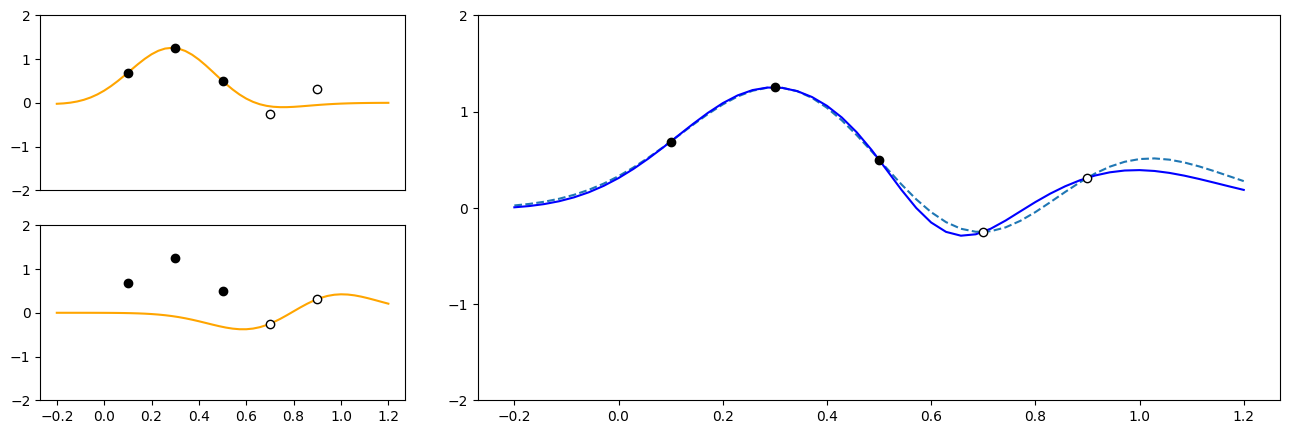

In [30]:
fig = plt.figure(figsize=(16, 5))
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (1, 0))
ax3 = plt.subplot2grid((2, 3), (0, 1), rowspan=2, colspan=2)

ticks = np.arange(-2,3)

ax1.plot(X_aux_graph, Y_K_1, c='orange')
ax1.scatter(X[A[0],:], Y[A[0]], c='k', zorder=3)
ax1.scatter(X[A[1],:], Y[A[1]], c='w', edgecolors='k', zorder=3)
ax1.set_xticks([])
ax1.set_yticks(ticks)

ax2.plot(X_aux_graph, Y_K_2, c='orange')
ax2.scatter(X[A[0],:], Y[A[0]], c='k', zorder=3)
ax2.scatter(X[A[1],:], Y[A[1]], c='w', edgecolors='k', zorder=3)
ax2.set_yticks(ticks)

ax3.plot(X_aux_graph, Y_K, ls='--')
ax3.plot(X_aux_graph, Y_NK, c='b')

ax3.scatter(X[A[0],:], Y[A[0]], c='k', zorder=3)
ax3.scatter(X[A[1],:], Y[A[1]], c='w', edgecolors='k', zorder=3)
ax3.set_yticks(ticks)

plt.show()